<a href="https://colab.research.google.com/github/OscarPellicer/A-New-Coefficient-of-Correlation/blob/main/Part_1_Physics_Informed_Neural_Networks_for_Inverse_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 — Inverse Modeling with PINNs

In this notebook we learn how to **estimate an unknown physical parameter** from limited data **using physics-informed neural networks**.

We revisit our familiar **1D damped harmonic oscillator**:

$$
m\frac{d^2x}{dt^2} + \mu\frac{dx}{dt} + kx = 0,
$$
with the initial conditions
$$
x(0) = 1 \, , \quad \frac{dx}{dt}\bigg\rvert_{t=0} = 0.
$$

---

This time, $m$ (the *mass*) is *unknown*.
We'll train a PINN to **infer \(m\)** while fitting the data and satisfying the differential equation.
This notebook is inspired by the [blog post of Ben Moseley](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/).

In [1]:
#@title Install & imports (run first)
!pip install -q torch torchvision matplotlib numpy

In [2]:
# Imports and setup
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)
torch.manual_seed(1234)
np.random.seed(1234)


Device: cpu


## Step 1 — Generate synthetic data

We'll use the *analytical solution* of the underdamped oscillator to produce data with **true parameters**:
- $m_\text{true} = 1.5$
- $\mu = 0.3$
- $k = 4.0$

We'll only provide the network with a few early-time data points. It must infer $m$ from those and from the physics constraint.


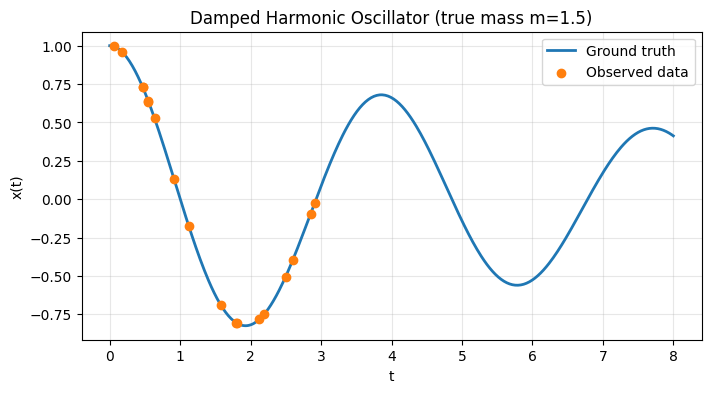

In [3]:
# Ground truth generator
def oscillator_gt(t, m=1.5, mu=0.3, k=4.0, x0=1.0, v0=0.0):
    t = np.asarray(t, dtype=float)
    gamma = mu / m
    omega0 = np.sqrt(k / m)
    disc = omega0**2 - (gamma**2) / 4.0
    if disc > 0:
        omega_d = np.sqrt(disc)
        A = x0
        B = (v0 + (gamma/2.0)*A) / omega_d
        x = np.exp(-(gamma/2.0)*t) * (A*np.cos(omega_d*t) + B*np.sin(omega_d*t))
    else:
        x = np.exp(-(gamma/2.0)*t) * (x0 + (v0 + (gamma/2.0)*x0)*t)
    return x

# True parameters
m_true, mu, k = 1.5, 0.3, 4.0
x0_val, v0_val = 1.0, 0.0

# Time domain
t0, t_max_data, t_max_model = 0.0, 3.0, 8.0
t_all = np.linspace(t0, t_max_model, 400)
x_all = oscillator_gt(t_all, m_true, mu, k, x0_val, v0_val)

# Sparse training data
N_data = 18
t_train = np.sort(np.random.RandomState(42).uniform(t0, t_max_data, N_data))
x_train = oscillator_gt(t_train, m_true, mu, k, x0_val, v0_val)

plt.figure(figsize=(8,4))
plt.plot(t_all, x_all, label="Ground truth", linewidth=2)
plt.scatter(t_train, x_train, color='tab:orange', label="Observed data", zorder=5)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Damped Harmonic Oscillator (true mass m=1.5)")
plt.legend(); plt.grid(alpha=0.3)
plt.show()


## Step 2 — Define the Neural Network Model

We'll use a simple **fully connected network** that takes time $t$ as input and predicts $x(t)$.

We also introduce a **trainable parameter** $\log m$ so that $m = e^{\log m}$ stays positive.


In [4]:
class MLP(nn.Module):
    def __init__(self, layers, activation=nn.Tanh):
        super().__init__()
        mods = []
        for i in range(len(layers)-1):
            mods.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                mods.append(activation())
        self.net = nn.Sequential(*mods)
        # Xavier init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
    def forward(self, t):
        return self.net(t)


## Step 3 — Helper: Derivatives with autograd


In [5]:
def time_derivative(u, t, order=1):
    deriv = u
    for _ in range(order):
        deriv = torch.autograd.grad(
            outputs=deriv,
            inputs=t,
            grad_outputs=torch.ones_like(deriv),
            create_graph=True,
            retain_graph=True,
        )[0]
    return deriv

## Step 4 — Prepare tensors and instantiate model


In [60]:
# Convert data to tensors
t_train_t = torch.tensor(t_train.reshape(-1,1), dtype=torch.float32, device=device)
x_train_t = torch.tensor(x_train.reshape(-1,1), dtype=torch.float32, device=device)

# Collocation points (physics)
N_collocation = 400
t_collocation_t = torch.tensor(
    np.random.RandomState(0).uniform(t0, t_max_model, N_collocation).reshape(-1,1),
    dtype=torch.float32, device=device, requires_grad=True)

# Initial conditions
t0_t = torch.tensor([[0.0]], dtype=torch.float32, device=device, requires_grad=True)
x0_t = torch.tensor([[x0_val]], dtype=torch.float32, device=device)
v0_t = torch.tensor([[v0_val]], dtype=torch.float32, device=device)

# Instantiate network and trainable parameter
model = MLP([1,128,128,128,1], activation=nn.Tanh).to(device)
log_m = torch.nn.Parameter(torch.tensor([np.log(1.0)], dtype=torch.float32, device=device, requires_grad=True))
log_mu = torch.nn.Parameter(torch.tensor([np.log(0.5)], dtype=torch.float32, device=device, requires_grad=True))
log_k = torch.nn.Parameter(torch.tensor([np.log(10.0)], dtype=torch.float32, device=device, requires_grad=True))
print("Initial mass guess m ≈", float(torch.exp(log_m).item()))
print("Initial mass guess mu ≈", float(torch.exp(log_mu).item()))
print("Initial mass guess k ≈", float(torch.exp(log_k).item()))


Initial mass guess m ≈ 1.0
Initial mass guess mu ≈ 0.5
Initial mass guess k ≈ 10.0


## Step 5 — Define the loss terms

We combine three components:

$$
\mathcal{L} = \lambda_d \mathcal{L}_{\text{data}} + \lambda_p \mathcal{L}_{\text{phys}} + \lambda_{IC}\mathcal{L}_{IC}
$$

where
- **data loss:** fits measured $(x(t_i))$,
- **physics loss:** enforces $(m \ddot{x} + \mu \dot{x} + k x = 0)$,
- **IC loss:** enforces $(x(0)=x_0, \dot{x}(0)=v_0)$.

---

> 💡 **TODO:** Fill in the missing parts of the loss computation in the cell below.


In [61]:
# Hyperparameters
lambda_d, lambda_p, lambda_ic = 1.0, 10.0, 10.0
lr = 1e-3
optimizer = optim.Adam(list(model.parameters()) + [log_m, log_mu, log_k], lr=lr)
mse = nn.MSELoss()


In [67]:
# 🔧 Training loop (students fill missing parts marked as TODO)
num_epochs = 15000
history = {"m_est": [], "mu_est": [], "k_est": [], "loss_total": [], "loss_data": [], "loss_phys": [], "loss_ic": []}

for ep in range(num_epochs):
    model.train(); optimizer.zero_grad()

    # --- supervised data loss ---
    x_pred_data = model(t_train_t)
    loss_data = mse(x_pred_data, x_train_t)

    # --- physics residual ---
    # TODO: compute x_c = ...
    # TODO: compute first and second time derivatives
    # TODO: compute residual = m_est * x_tt + mu * x_t + k * x_c
    # HINT: use m_est = torch.exp(log_m)
    # loss_phys = mean squared residual
    # ===== YOUR CODE HERE =====
    x_c = model(t_collocation_t)
    x_t = time_derivative(x_c, t_collocation_t, order=1)
    x_tt = time_derivative(x_c, t_collocation_t, order=2)
    m_est = torch.exp(log_m)
    mu_est = torch.exp(log_mu)
    k_est = torch.exp(log_k)
    residual = m_est * x_tt + mu_est * x_t + k_est * x_c
    loss_phys = torch.mean(residual**2)
    # ==========================

    # --- initial condition loss ---
    x0_pred = model(t0_t)
    v0_pred = time_derivative(x0_pred, t0_t, order=1)
    loss_ic = mse(x0_pred, x0_t) + mse(v0_pred, v0_t)

    # --- total loss ---
    # TODO: combine into loss_total = ...
    loss_total = lambda_d * loss_data + lambda_p * loss_phys + lambda_ic * loss_ic

    # Backpropagation
    loss_total.backward()
    optimizer.step()

    # Logging
    with torch.no_grad():
        history["m_est"].append(float(torch.exp(log_m).item()))
        history["mu_est"].append(float(torch.exp(log_mu).item()))
        history["k_est"].append(float(torch.exp(log_k).item()))
        history["loss_total"].append(loss_total.item())
        history["loss_data"].append(loss_data.item())
        history["loss_phys"].append(loss_phys.item())
        history["loss_ic"].append(loss_ic.item())

    # Optional: print every few hundred epochs
    if (ep % 600 == 0) or (ep == num_epochs-1):
        # print(f"Epoch {ep:5d} | m_est={float(torch.exp(log_m).item()):.4f}")
        print(f"Epoch {ep:5d} | total {loss_total.item():.4e} | data {loss_data.item():.4e} | phys {loss_phys.item():.4e} | ic {loss_ic.item():.4e} | m_est {m_est.item():.4f} | mu_est {mu_est.item():.4f} | k_est {k_est.item():.4f}")


Epoch     0 | total 2.4575e+02 | data 3.4737e-01 | phys 2.3515e+01 | ic 1.0248e+00 | m_est 1.0000 | mu_est 0.5000 | k_est 10.0000
Epoch   600 | total 8.3848e+00 | data 3.4165e-01 | phys 1.1679e-01 | ic 6.8752e-01 | m_est 0.8246 | mu_est 0.7081 | k_est 9.5171
Epoch  1200 | total 1.4400e+00 | data 2.5324e-01 | phys 7.9790e-02 | ic 3.8886e-02 | m_est 0.6860 | mu_est 2.2271 | k_est 8.5340
Epoch  1800 | total 2.4519e-01 | data 2.1033e-01 | phys 3.4697e-03 | ic 1.6561e-05 | m_est 0.7075 | mu_est 3.0120 | k_est 8.1003
Epoch  2400 | total 2.0589e-01 | data 1.9927e-01 | phys 6.5520e-04 | ic 6.3505e-06 | m_est 0.7756 | mu_est 3.3223 | k_est 7.9229
Epoch  3000 | total 1.9537e-01 | data 1.9076e-01 | phys 4.5160e-04 | ic 9.3185e-06 | m_est 0.8580 | mu_est 3.5077 | k_est 7.7810
Epoch  3600 | total 1.8609e-01 | data 1.8201e-01 | phys 4.0025e-04 | ic 8.1540e-06 | m_est 0.9678 | mu_est 3.6452 | k_est 7.6288
Epoch  4200 | total 1.8594e-01 | data 1.7396e-01 | phys 1.1789e-03 | ic 1.9226e-05 | m_est 1.105

## Step 6 — Plot training progress

We’ll plot:
1. The learned trajectory $x_\theta(t)$ compared with the data and ground truth.
2. The inferred value of $m$ over training.


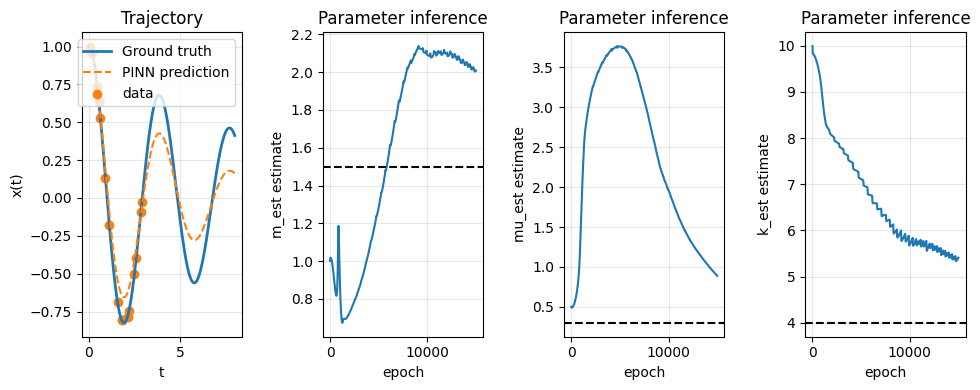

In [69]:
def plot_training_progress(history, t_all, x_all, model, log_m):
    model.eval()
    with torch.no_grad():
        x_pred = model(torch.tensor(t_all.reshape(-1,1), dtype=torch.float32, device=device)).cpu().numpy()
    plt.figure(figsize=(10,4))
    plt.subplot(1,4,1)
    plt.plot(t_all, x_all, label="Ground truth", linewidth=2)
    plt.plot(t_all, x_pred, '--', label="PINN prediction")
    plt.scatter(t_train, x_train, color='tab:orange', label="data")
    plt.xlabel("t"); plt.ylabel("x(t)")
    plt.legend(); plt.grid(alpha=0.3); plt.title("Trajectory")

    for i, (param_true, param_name) in enumerate(zip(
                 [m_true, mu, k], ['m_est', 'mu_est', 'k_est'])):
      plt.subplot(1,4,i+2)
      plt.plot(history[param_name], label=f"estimated {param_name}")
      plt.axhline(param_true, color='black', linestyle='--', label=f"true {param_name}")
      plt.xlabel("epoch"); plt.ylabel(f"{param_name} estimate")
      plt.grid(alpha=0.3); plt.title("Parameter inference")
      # plt.legend();

    plt.tight_layout(); plt.show()

# 🔍 After training (once students fill in the missing parts), run:
plot_training_progress(history, t_all, x_all, model, log_m)


## Discussion

- How does the inferred mass $m$ evolve during training?
- What happens if we change the number of data points or collocation points?
- How sensitive is the estimation to the weighting of the losses?

---

**Goal:** Participants should fill in the missing parts of the physics loss and total loss definitions to make the PINN infer \(m\).

---

**Expected result:**  
The PINN should converge to $m_\text{est} \approx 1.5$, and the predicted trajectory should closely match the ground truth beyond the data region.
